# GPT

In [1]:
#%pip install trl
#%pip install -U transformers==4.38.1

In [2]:
# one of these settings will allow the batch size to be set
#%pip install -q -U trl==0.7.10
#%pip install -q -U datasets==2.17.0
#%pip install -q -U transformers==4.38.1
#%pip install accelerate

In [3]:
from transformers import pipeline, AutoTokenizer
from datasets import load_dataset

from trl import PPOTrainer, PPOConfig, AutoModelForCausalLMWithValueHead
from trl.core import LengthSampler

import pandas as pd

import torch
from torch.utils.data import Dataset
from transformers import TrainingArguments, Trainer, pipeline
from sklearn.metrics import accuracy_score, f1_score
import json
from datasets import load_dataset, Split

from transformers import BertTokenizerFast, BertForSequenceClassification
import tqdm

C:\Users\joeya\anaconda3\envs\its520v2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Data

In [4]:
rlhf = 'movies-all'

In [5]:
dataset = load_dataset("csv", data_files=f"{rlhf}.csv", split=Split.ALL)

In [6]:
dataset

Dataset({
    features: ['adult', '28', '12', '16', '35', '80', '99', '18', '10751', '14', '36', '27', '10402', '9648', '10749', '878', '10770', '53', '10752', '37', 'overview'],
    num_rows: 131262
})

In [7]:
df_sample = pd.DataFrame(dataset)

df_sample['overview'] = df_sample['overview'].str.split('.')
df_sample = df_sample.explode('overview', ignore_index=True)

display(df_sample)
# must be randomized, otherwise val is all one language
df_data = df_sample.sample(frac=1.0) # return all in random order

import datasets as dt
dataset = dt.Dataset.from_pandas(df_data)

,adult,28,12,16,35,80,99,18,10751,14,...,27,10402,9648,10749,878,10770,53,10752,37,overview
0,False,True,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,False,Characters from different backgrounds are thro...
1,False,True,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,False,A nightmare fight for survival ensues with th...
2,False,True,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,False,
3,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,True,False,When a Delta Force special ops mission goes te...
4,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,True,False,With no weapons and no communication other th...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
432759,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,
432760,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,Stylish adult western from Rinse Dream
432761,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,
432762,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,Western stylized adult film from Rinse Dream


In [8]:
display(pd.DataFrame(dataset[:5]))

,adult,28,12,16,35,80,99,18,10751,14,...,10402,9648,10749,878,10770,53,10752,37,overview,__index_level_0__
0,False,False,True,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,Nano confesses that his father is the strange...,67584
1,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,None,334583
2,False,False,False,False,False,True,False,True,False,False,...,False,False,False,False,False,True,False,False,,155560
3,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,,365285
4,False,True,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,Alex is a comrade and an active communist leader,29203


## Setup Model

In [9]:
config = PPOConfig(
    model_name    = "lvwerra/gpt2-imdb",#"google/gemma-2b",#"lvwerra/gpt2-imdb",#'EleutherAI/gpt-neo-1.3B',#"google/gemma-2b",
    learning_rate = 1.41e-5,
    ## log_with      = "wandb",
    batch_size=128, # 128
    # gradient_accumulation_steps=1,
)
print(config.batch_size)

sent_kwargs = {
         "return_all_scores": True, 
         "function_to_apply": "none", 
         "batch_size": 16
}

128


In [10]:
tokenizer           = AutoTokenizer.from_pretrained(config.model_name)
tokenizer.pad_token = tokenizer.eos_token

In [11]:
def tokenize(sample):
        input_size = LengthSampler(2, 8)
        sample["input_ids"] = tokenizer.encode( sample["overview"]    )[: input_size()]
        sample["query"]     = tokenizer.decode( sample["input_ids"] )
        return sample

dataset = dataset.filter(lambda x: x['overview'] != None and len(x["overview"]) > 100 and len(x['overview']) < 512
                         , batched=False)
dataset = dataset.map(tokenize, batched=False)
dataset.set_format(type="torch")
print(len(dataset))

Map: 100%|████████████████████████████████████████████████████████████| 158516/158516 [01:20<00:00, 1968.90 examples/s]

158516


In [12]:
def collator(data):
    return dict((key, [d[key] for d in data]) for key in data[0])

In [13]:
model     = AutoModelForCausalLMWithValueHead.from_pretrained(config.model_name)#, torch_dtype=torch.float16)
ref_model = AutoModelForCausalLMWithValueHead.from_pretrained(config.model_name)#, torch_dtype=torch.float16)
print(model)

ppo_trainer = PPOTrainer(
                 config, 
                 model, 
                 ref_model,
                 tokenizer, 
                 dataset=dataset, 
                 data_collator=collator
)

device = 'cuda'

C:\Users\joeya\anaconda3\envs\its520v2\lib\site-packages\torch\_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


AutoModelForCausalLMWithValueHead(
  (pretrained_model): GPT2LMHeadModel(
    (transformer): GPT2Model(
      (wte): Embedding(50257, 768)
      (wpe): Embedding(1024, 768)
      (drop): Dropout(p=0.1, inplace=False)
      (h): ModuleList(
        (0-11): 12 x GPT2Block(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): GPT2Attention(
            (c_attn): Conv1D()
            (c_proj): Conv1D()
            (attn_dropout): Dropout(p=0.1, inplace=False)
            (resid_dropout): Dropout(p=0.1, inplace=False)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): GPT2MLP(
            (c_fc): Conv1D()
            (c_proj): Conv1D()
            (act): NewGELUActivation()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
      )
      (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    )
    (lm_head): Linear(in_features=768, out_features=50257, bias=False)
  )
  (

### Gemma Problems
- Laptop
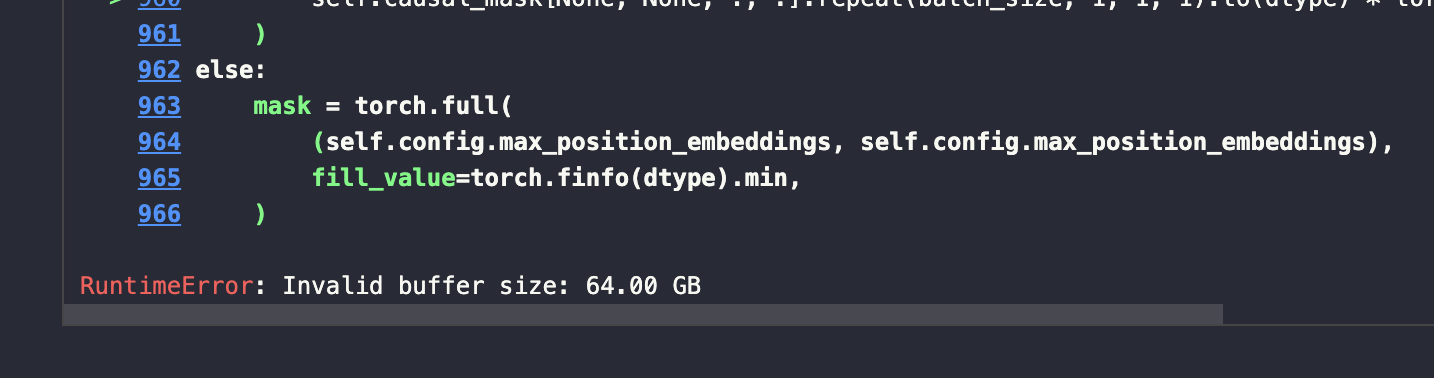
- Purdue Scholar
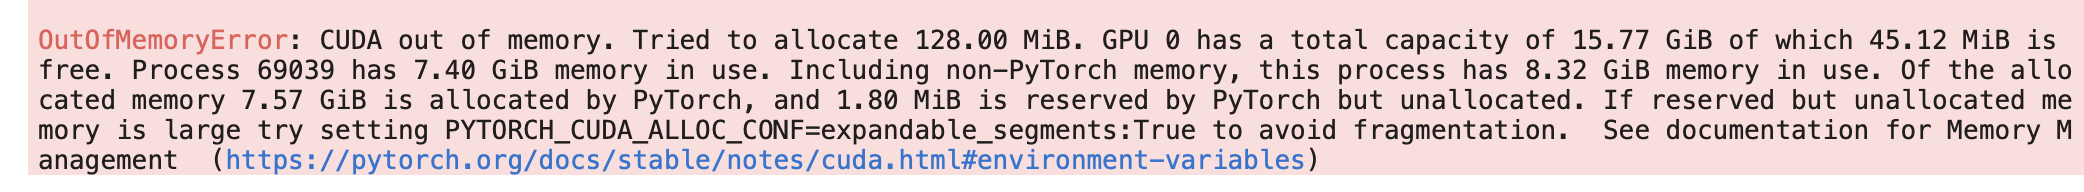
- stuff
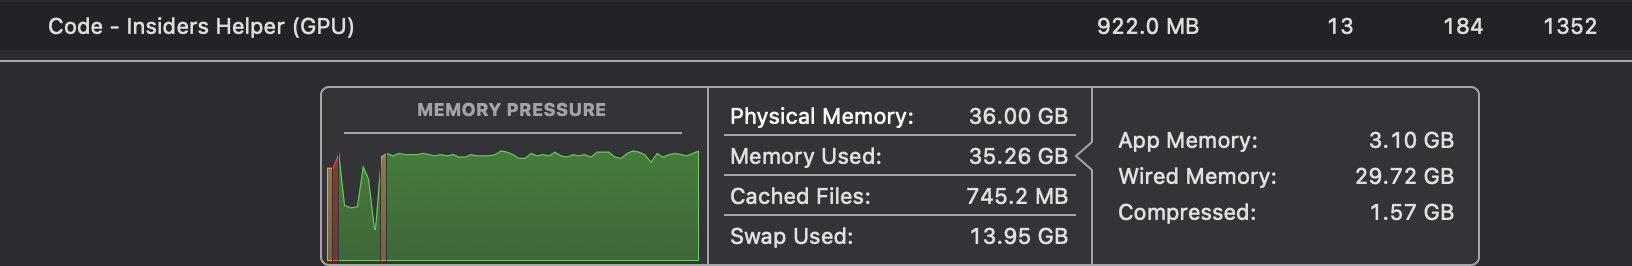

## Load Classifier (Reward Functino)

In [14]:
# i guess it makes sense they cant have the same tokenizer
model_class     = BertForSequenceClassification.from_pretrained(f"movie-model/final-trainer")
tokenizer_class = BertTokenizerFast.from_pretrained("bert-base-uncased")
print(tokenizer)

sent_kwargs = {
         "return_all_scores": True, 
         "function_to_apply": "none", 
         "batch_size": 16
}

nlp = pipeline("sentiment-analysis", model=model_class, tokenizer=tokenizer_class, device=device)

GPT2TokenizerFast(name_or_path='lvwerra/gpt2-imdb', vocab_size=50257, model_max_length=1024, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<|endoftext|>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	50256: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
}


In [15]:
text = "A Street Kid trying to survive in a technology and body modification-obsessed \
city of the future. Having everything to lose, he chooses to stay alive by becoming an Edgerunner, \
a Mercenary outlaw also known as a Cyberpunk."
nlp(text, **sent_kwargs)

C:\Users\joeya\anaconda3\envs\its520v2\lib\site-packages\transformers\pipelines\text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


[[{'label': '28', 'score': -0.6236483454704285},
  {'label': '53', 'score': -0.26520615816116333},
  {'label': '35', 'score': 0.21349501609802246}]]

## Generator

In [29]:
gen_kwargs = {
         "min_length":   -1, 
         "top_k":       0.0, 
         "top_p":       1.0, 
         "do_sample":  True, 
         "pad_token_id": tokenizer.eos_token_id,
}

# find the index of the label to mimic
mimic = 'Horror'
output = nlp("a", **sent_kwargs)[0]
for mi, x in enumerate(output):
    if x['label'] == mimic:
        break
else:
    raise ValueError(f"couldn't find {mimic}")

C:\Users\joeya\anaconda3\envs\its520v2\lib\site-packages\transformers\pipelines\text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
C:\Users\joeya\anaconda3\envs\its520v2\lib\site-packages\transformers\pipelines\base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


ValueError: couldn't find Horror

In [17]:
mi = 1

In [18]:
output_min_length     = 4
output_max_length     = 16
output_length_sampler = LengthSampler(output_min_length, output_max_length)

In [19]:
pbar = tqdm.tqdm(enumerate(ppo_trainer.dataloader), total=len(ppo_trainer.dataloader))
for epoch, batch in pbar:
    query_tensors = batch["input_ids"]

    #### Get response from gpt2
    response_tensors = []
    for i, query in enumerate(query_tensors):
        pbar.set_description(f"{i} / {len(query_tensors)}")
        gen_len                             = output_length_sampler()
        gen_kwargs["max_new_tokens"] = gen_len
        response                            = ppo_trainer.generate(query, **gen_kwargs)
        response_tensors.append( response.squeeze()[-gen_len:] )
    batch["response"] = [ tokenizer.decode(r.squeeze()) for r in response_tensors ]

    #### Compute sentiment score
    pbar.set_description("Sentiment")
    texts = [q + r for q, r in zip(batch["query"], batch["response"])]
    pipe_outputs = nlp(texts, **sent_kwargs)
    rewards = [ torch.tensor(output[mi]["score"]) for output in pipe_outputs]
    print(batch["query"], batch["response"], rewards, sep="\n")

    #### Run PPO step
    pbar.set_description("PPO")
    stats = ppo_trainer.step(
                     query_tensors, 
                     response_tensors, 
                     rewards
    )
    ppo_trainer.log_stats(stats, batch, rewards)

PPO:   0%|                                                                                    | 0/1238 [00:14<?, ?it/s]

['Samantha Hart is delighted', ' The film also', ' This self-defined family is', 'In his homeland of', '  The heroes seem', 'Two Turkish anti-terrorist agents', 'One year after their incredible adventures', ' With these', ' Both sets are wonderful', ' Years later they gather', 'A subversive tale that interlaces', 'Ben, Gwen, and Max', '  Whilst there he witnesses the grim', 'In his early twenties, Sam', ' Two track that were performed', 'Medfield College science', 'So-jeong, who lives', 'A photographer in a', 'After being assigned', 'Elmer F', "If you're a younger", ' Eade and her dad', 'Whopper, Stan', '"For Sale! Including 500 violent', ' The plot of', ' It is because she promised', ' It demonstrates the skills of', 'Based on the extraordinary true story of', ' Will it be newbie', 'In response to the financial crisis set', ' Their destination was the 15th-', ' Follows his all', ' This time', ' The two', 'FBI agent Lee H', 'After killing one person and', ' Ara, who', 'Two sisters', ' 

PPO:   0%|                                                                          | 1/1238 [00:30<5:22:47, 15.66s/it]

PPO:  99%|██████████████████████████████████████████████████████████████████████▍| 1229/1238 [8:04:56<06:27, 43.07s/it]

[" The elephant's corpse however, was", 'Moments of Ext', 'While attempting to help Frankie Stein', 'Uncle Beans and the kids', ' At that time, little', ' Before he kicks the', ' Victim of a sexual assault that goes', 'The first film in', ' Masters must navigate a fractured friendship', 'During WWII,', ' Some other inter', 'Tells the story of Jesus Christ', ' A determined foe with superior', ' Can the aging underdog', ' Homophobic Alice March', 'Snot and Splash travel', ' Unfortunately, this engaging 45', ' Now everybody wants to', ' Now, he', 'Commissar Ali-Ak', 'The Yule Log is a television', 'Hal LeRoy', ' Blue and', ' Place a simple online', "After a couple of '", " The villain's", 'Muggsy', 'The film tells about the founder', '" Will the', ' Her paraph', 'The bizarre temptation of an', 'Ben Sanderson,', 'The plot is based on', ' Supported by', ' He gets', ' Several years', ' The documentary', 'A disfigured musical genius, hidden', ' However, their', ' While on his way he', ' Turne

PPO:  99%|██████████████████████████████████████████████████████████████████████▍| 1229/1238 [8:04:58<03:33, 23.68s/it]


KeyboardInterrupt: 

## Get the Results

In [20]:
bs                 = 16
game_data          = {}

dataset.set_format("pandas")
df_batch           = dataset[:].sample(bs)
df_batch 

,adult,28,12,16,35,80,99,18,10751,14,...,10749,878,10770,53,10752,37,overview,__index_level_0__,input_ids,query
32459,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,Inspired by thousands of witness accounts doc...,295433,"[45827, 416]",Inspired by
129259,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,A parent concerned about the violence and poss...,388790,"[32, 2560, 5213, 546, 262, 3685, 290]",A parent concerned about the violence and
66599,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,The film follows the extended Bowling family...,177688,"[220, 383, 2646, 5679, 262]",The film follows the
93018,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,"A young YouTuber, ""Ludovico 122"", will try to...",282217,"[317, 1862, 921, 51]",A young YouT
135545,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,"Traumatized as an adult, his psychiatrist rec...",297611,"[4759, 27798, 1143, 355, 281, 4044, 11]","Traumatized as an adult,"
156029,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,True story of the undersized Depression-era ra...,202888,"[17821, 1621, 286, 262, 14584, 1143, 22483]",True story of the undersized Depression
113840,False,False,True,True,False,False,False,False,True,False,...,False,False,False,False,False,False,"When Nobita feels like diving in his hometown,...",37737,"[2215, 8140, 5350]",When Nobita
3682,False,True,True,True,False,False,False,True,False,False,...,False,True,False,False,False,False,"Harlock, a captain in earth's fleet, crashes ...",13294,"[2113, 5354, 11, 257, 10654, 287]","Harlock, a captain in"
10780,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,A brother and sister on the fringe of society ...,377684,"[32, 3956, 290, 6621, 319, 262, 26821]",A brother and sister on the fringe
72888,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,The Joy of Christmas combines the talent of th...,238979,"[464, 14087, 286, 6786, 21001, 262]",The Joy of Christmas combines the


In [21]:
game_data["query"] = df_batch["query"].tolist()
query_tensors      = df_batch["input_ids"].tolist()
response_tensors_ref, response_tensors = [], []
#### get response from gpt2 and gpt2_ref
for i in range(bs):
    gen_len = output_length_sampler()
    
    output  = ref_model.generate(
        torch.tensor(query_tensors[i]).unsqueeze(dim=0).to(device), **gen_kwargs
    ).squeeze()[-gen_len:]
    response_tensors_ref.append(output)
    
    
    output = model.generate(
        torch.tensor(query_tensors[i]).unsqueeze(dim=0).to(device), **gen_kwargs
    ).squeeze()[-gen_len:]
    response_tensors.append(output)

In [22]:
game_data["response (before)"] = [tokenizer.decode(response_tensors_ref[i]) for i in range(bs)]
game_data["response (after)"]  = [tokenizer.decode(response_tensors[i]) for i in range(bs)]

#### sentiment analysis of query/response pairs before/after
texts = [q + r for q, r in zip(game_data["query"], game_data["response (before)"])]
game_data["rewards (before)"] = [output[mi]["score"] for output in nlp(texts, **sent_kwargs)]

texts = [q + r for q, r in zip(game_data["query"], game_data["response (after)"])]
game_data["rewards (after)"] = [output[mi]["score"] for output in nlp(texts, **sent_kwargs)]

# store results in a dataframe
df_results = pd.DataFrame(game_data)
df_results

C:\Users\joeya\anaconda3\envs\its520v2\lib\site-packages\transformers\pipelines\text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
C:\Users\joeya\anaconda3\envs\its520v2\lib\site-packages\transformers\pipelines\base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


,query,response (before),response (after),rewards (before),rewards (after)
0,Inspired by,French historical period of photographer Bulg...,visitor. Jack Evans was able to,0.520095,1.294056
1,A parent concerned about the violence and,My husband picked it to spend lunch,child and her children are trying to,1.220142,2.839684
2,The film follows the,follows the main plot of Geraldine Perkins (S...,follows the traumatic aftermath of the lives ...,2.289029,2.966988
3,A young YouT,A young YouTuber named Garrison Andrews was a...,A young YouTuber promptly puts his vile head ...,0.917147,2.147344
4,"Traumatized as an adult,","adult, brought to tears when she was abandone...","adult, he is haunted by his exile into a trou...",3.083684,3.162497
5,True story of the undersized Depression,ized Depression people looking for something t...,ized Depression Theater tells horrific and con...,-1.304828,2.939359
6,When Nobita,aging son is too old to,"by her sister, before she",-1.993055,-1.953378
7,"Harlock, a captain in",", a captain in WWII whose used to be with the ...",", a captain in a hostile ship. The sexually vi...",-1.299118,2.457836
8,A brother and sister on the fringe,"the fringe of society, to be regular citizens...",the fringe of a family disease deal with a wa...,-0.325380,2.167929
9,The Joy of Christmas combines the,Christmas to provide a cinematic feast for all,ism of Halloween with the chilling sensibiliti...,-2.576634,0.891195


In [23]:
print("mean:")
display(df_results[["rewards (before)", "rewards (after)"]].mean())
print()
print("median:")
display(df_results[["rewards (before)", "rewards (after)"]].median())

mean:


rewards (before)   -0.362152
rewards (after)     1.760694
dtype: float64


median:


rewards (before)   -0.594370
rewards (after)     2.157637
dtype: float64

## Save the Model

In [24]:
model.save_pretrained(    f"{rlhf}-model/gpt2-{mimic}", push_to_hub=False)
tokenizer.save_pretrained(f"{rlhf}-model/tokenizer-{mimic}", push_to_hub=False)

('movies-all-model/tokenizer-Romance\\tokenizer_config.json',
 'movies-all-model/tokenizer-Romance\\special_tokens_map.json',
 'movies-all-model/tokenizer-Romance\\vocab.json',
 'movies-all-model/tokenizer-Romance\\merges.txt',
 'movies-all-model/tokenizer-Romance\\added_tokens.json',
 'movies-all-model/tokenizer-Romance\\tokenizer.json')

In [25]:
print(torch.mps.current_allocated_memory()/1024/1024)
torch.cuda.memory_summary()

RuntimeError: Cannot execute getCurrentAllocatedMemory() without MPS backend.

## Test Model

In [26]:
from IPython.display import display, HTML

In [27]:
model = AutoModelForCausalLMWithValueHead.from_pretrained(f"{rlhf}-model/gpt2-{mimic}").to(device)
tokenizer= AutoTokenizer.from_pretrained(f"{rlhf}-model/tokenizer-{mimic}") # BertTokenizerFast

Some weights of the model checkpoint at movies-all-model/gpt2-Romance were not used when initializing GPT2LMHeadModel: ['v_head.summary.bias', 'v_head.summary.weight']
- This IS expected if you are initializing GPT2LMHeadModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2LMHeadModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [28]:
dataset.set_format("pandas")
df_batch           = dataset[:].sample(1)

print(df_batch["query"].tolist())

#### get response from gpt2 and gpt2_ref
response_tensor = torch.tensor(df_batch["input_ids"].tolist()[0], device=device)
while response_tensor[-1] != tokenizer.eos_token_id:
    gen_len = output_length_sampler()
    
    output = model.generate(
        torch.tensor(query_tensors[i]).unsqueeze(dim=0).to(device), **gen_kwargs
    ).squeeze()[-gen_len:]

    # print(tokenizer.decode(output))
    response_tensor = torch.cat((response_tensor, output))

print(tokenizer.decode(response_tensor))
display(HTML(tokenizer.decode(response_tensor)))

['In order to']
In order toRescue. It had to be the definitive violent cinemaescue (2004) is particularly disturbing because the torture overwhelming mass of horror wraps in what will become one of theRescue in Samantha's painful memory. Her suffering remains but viewed as a disturbing, disturbing, descend on a dark murder pit and makes the through the sentences that may beRescue it after a horrific day of terror despite thoseescue in which she committed. Possibly hysterical, but performances as the family are excruciating victims were overwhelmed with a, the trauma continues in special includes death scenes, horrific footage and horrificRescue doctor Bahrani starts a ritual of pureRescue subject to disturbing circumstances. A flashback sequence thatRescue victim Sharon White is not locked up like some suggests that a prisoner is in a misery chamberRescue: "Avoid the death penalty." "People, he produces a document tornescue aiming for a scene, he suddenly causes blindnessRescueendix pr